# Make-Head-Disappear Experiment

Note: This experiment is not discussed in the report.

### Setup

In [ ]:
!python src/data/setup.py

In [1]:
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable

print ('GPU Model: ', torch.cuda.get_device_name(torch.cuda.current_device()))

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import shutil

from src.models import model
from src.utils import save
from src.utils.helpers import makedir, plot_grid_on_image

from src.utils.local_analysis import LocalAnalysis

from settings import colab, username

from src.data.setup import setup_test_image
setup_test_image(idx=839)

import sys
sys.path.insert(0, 'src/models/')

GPU Model:  GeForce GTX 1080
Image id: 839.	IsTrain: 0
File name: 016.Painted_Bunting/Painted_Bunting_0004_16641.jpg


### Load Test Image and Model

- Set `test_image_name` to the file name of the test image to be analysed and also the true `test_image_label`. 
- Set the appropriate path to copy the file to the folder `local_analysis`.
- Set the path to the save model in `load_model_dir` and the model file name in `load_model_name`.

In [2]:
# specify the test image to be analyzed

test_image_name = 'Painted_Bunting_0004_16641.jpg'
filename = test_image_name[:-4]
if colab:
    test_image_dir = '/content/PPNet/local_analysis/{}/'.format(filename)
else:
    test_image_dir = '/scratch/PPNet/local_analysis/{}/'.format(filename)

test_image_label = 15 #15
makedir(test_image_dir)

# please set the folder name manually [format: class label.name]

# for leonhard
!cp /scratch/PPNet/datasets/cub200_cropped/test_cropped/016.Painted_Bunting/"$test_image_name" /scratch/PPNet/local_analysis/"$filename"/

# for colab
# !cp /content/datasets/cub200_cropped/test_cropped/016.Painted_Bunting/"$test_image_name" /content/local_analysis/"$filename"/

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

test_image_path = os.path.join(test_image_dir, test_image_name)

# load the model
if colab:
    load_model_dir = '/content/PPNet/saved_models/resnet18/003/'
else:
    load_model_dir = '/cluster/scratch/{}/PPNet/saved_models/resnet18/003/'.format(username)
load_model_name = '40push0.7437.pth'

In [4]:
la = LocalAnalysis(load_model_dir, load_model_name, test_image_name, attack=3)
img_size = la.img_size

# load the test image and forward it through the network
preprocess = transforms.Compose([
   transforms.Resize((img_size, img_size)),
   transforms.ToTensor(),
   la.normalize
])
    
img_pil = Image.open(test_image_path)
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))

load model from /cluster/scratch/rarade/PPNet/saved_models/resnet18/003/40push0.7437.pth
model base architecture: resnet18
experiment run: 003
Prototypes are chosen from 200 number of classes.
Their class identities are: [  0   0   0 ... 199 199 199]
All prototypes connect most strongly to their respective classes.


### Local Analysis: Original Image

Predicted: 15
Actual: 15
Prediction is correct.
image index 0 in batch
Most activated 10 prototypes of this image:
--------------------------------------------------------------
top 1 activated prototype for this image:
prototype index: 150
prototype class identity: 15
activation value (similarity score): 5.093625545501709
last layer connection with predicted class: 1.100566029548645


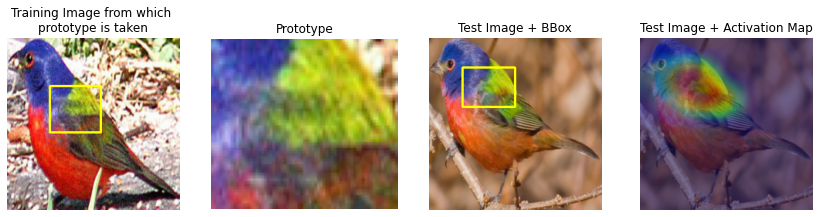

--------------------------------------------------------------
top 2 activated prototype for this image:
prototype index: 152
prototype class identity: 15
activation value (similarity score): 4.846137523651123
last layer connection with predicted class: 1.1776697635650635


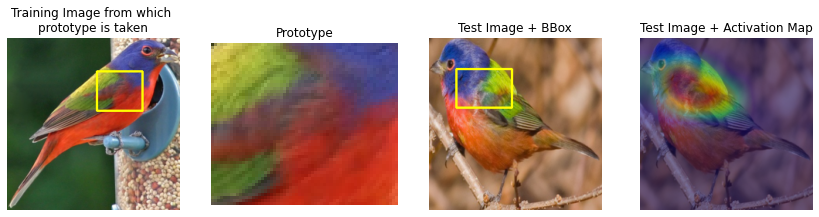

--------------------------------------------------------------


In [5]:
_, _, normalize_sim_map = la.local_analysis(img_variable, test_image_label, max_prototypes=2, show_images=True)

### Attack 3: Reduce Simlarity with a Prototype

image index 0 in batch
Attacking prototype: 150
Similarity with prototype 150 before attack is 5.094854


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Similarity with prototype 150 after attack is 0.421048


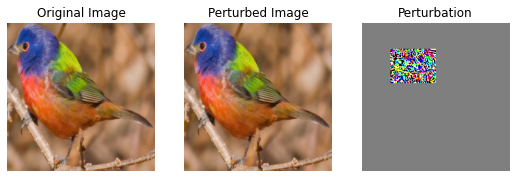

In [6]:
PID = 150
images_perturbed, _ = la.attack3(img_variable, pid=PID, idx=0)

### Local Analysis: Attacked Image

Note: Ypu might need to perform multiple random restarts. The activation map is rescaled so that it is on the same scale as the earlier one (this makes it appealing for visual inspection).

Predicted: 135
Actual: 15
Prediction is wrong.
image index 0 in batch
Most activated 10 prototypes of this image:
--------------------------------------------------------------
top 833 activated prototype for this image:
prototype index: 150
prototype class identity: 15
activation value (similarity score): 0.4210476279258728
last layer connection with predicted class: 1.627909114176873e-05


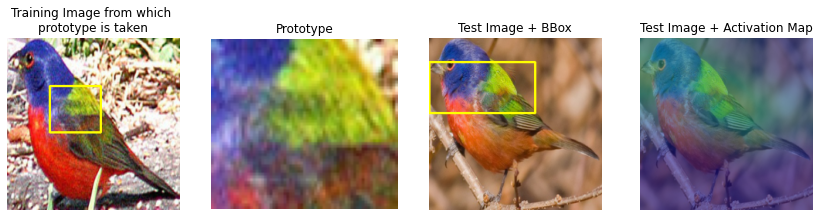

--------------------------------------------------------------


In [7]:
_, _, _ = la.local_analysis(la.normalize(images_perturbed.squeeze(0)).unsqueeze(0), test_image_label, 
                            max_prototypes=2000, pid=PID, show_images=True, normalize_sim_map=normalize_sim_map)

### Save Results

In [8]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [9]:
import time
time.sleep(2)

la.logclose()

temp = la.save_analysis_path
file_name = '{}-{}.html'.format(test_image_name[:-4], PID)
for file in os.listdir(temp):
    if os.path.isdir(temp + '/' + file):
        shutil.rmtree(temp + '/' + file)
    else:
        os.remove(temp + '/' + file)
    
!jupyter nbconvert --to html local_analysis_attack3.ipynb --output-dir="$la.save_analysis_path" --output "$file_name"

[NbConvertApp] Converting notebook local_analysis_attack3.ipynb to html
[NbConvertApp] Writing 1274067 bytes to /cluster/scratch/rarade/PPNet/local_analysis_attack3/resnet18-003/Painted_Bunting_0004_16641/Painted_Bunting_0004_16641-150.html
